In [1]:
import os

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA


import gym_env
from models import LinearRL, SR_TD

In [2]:
# Set the seed
seed = 1234
np.random.seed(seed)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
def spectral_regularization(sr, n_components, gamma_large):
    u, s, vt = np.linalg.svd(sr)
    s_reg = s[:n_components] * (1 - gamma_large) / (1 - gamma_large * s[:n_components])
    sr_reg = (u[:, :n_components] * s_reg) @ vt[:n_components, :]
    return np.maximum(sr_reg, 0)  # Thresholding at 0

def visualize_sr_enhanced(agent, sr, y=8, x=5, n_components=40, gamma=0.99):
    # Apply spectral regularization
    sr_reg = spectral_regularization(sr, n_components, gamma)

    # Use Incremental PCA (which is similar to CCIPCA)
    ipca = IncrementalPCA(n_components=y*x)
    result = ipca.fit_transform(sr_reg.T)
    result = np.clip(result, 0, 1)  # Thresholding at 0

    fig, axs = plt.subplots(x, y, figsize=(y * 3, x * 3))

    for j in range(x):
        for i in range(y):
            axs[j, i].axis("off")
            axs[j, i].imshow(
                result[:, (i + (j * y))].reshape(agent.height, agent.width),
                cmap="jet"
            )
    
    plt.tight_layout()
    plt.show()

In [4]:
# Define grid field plotting
def visualize_grid_fields(agent, sr, y=8, x=5):
    pca = PCA(n_components=y * x, svd_solver="full")
    result = pca.fit_transform(sr.T)
    result = np.clip(result, 0, 1)

    fig, axs = plt.subplots(x, y, figsize=(y * 3, x * 3))

    for j in range(x):
        for i in range(y):
            axs[j, i].axis("off")
            axs[j, i].imshow(
                result[:, (i + (j * y))].reshape(agent.height, agent.width),
                cmap="jet"
            )
    
    plt.tight_layout()
    plt.show()

In [5]:
# Hyperparams
num_steps = 100000

## Open Field No Goal

### SR Agent

In [22]:
sr_agent = SR_TD(env_name="open-field-no-goal-large", num_steps=200000, gamma=0.99)

In [23]:
sr_agent.maze.shape

(21, 21)

In [24]:
# agent randomly traverses maze
sr_agent.learn(seed=seed)

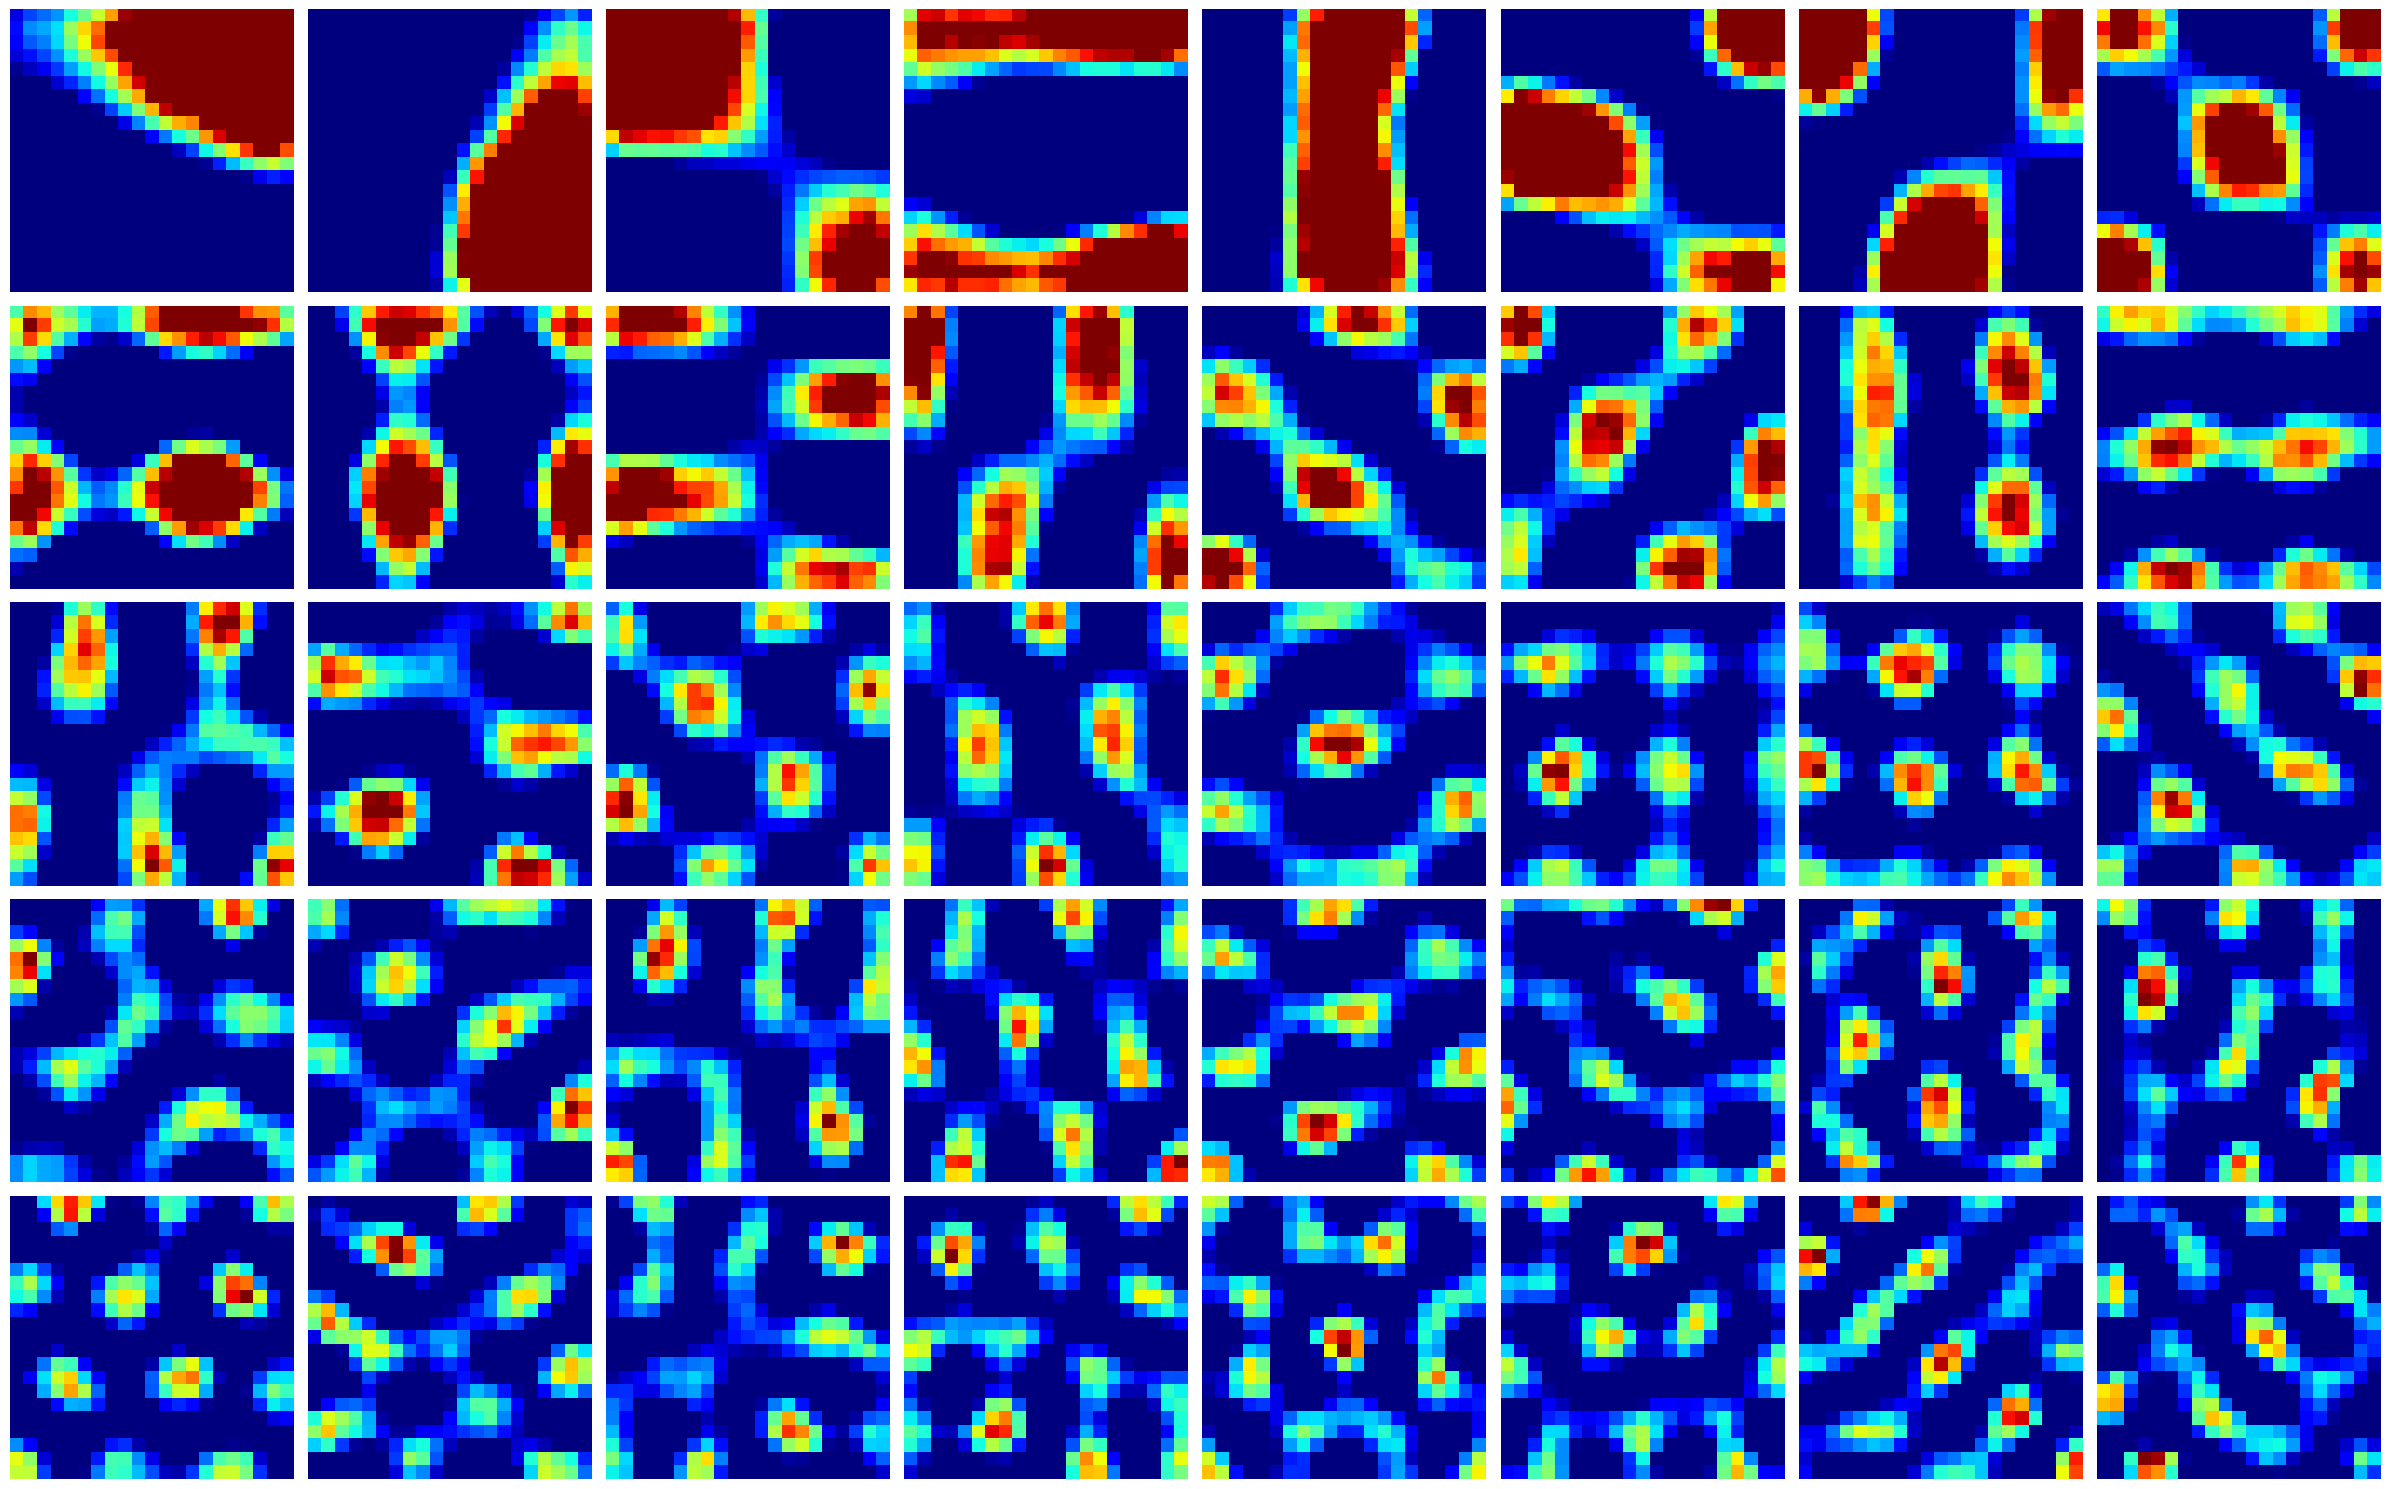

In [25]:
visualize_grid_fields(sr_agent, sr_agent.SR)

### SR-Imp Agent

In [26]:
sr_imp_agent = LinearRL(env_name="open-field-no-goal-large", num_steps=200000, reward=-0.01)
sr_imp_agent.learn(seed=seed)

/Users/abizzle/Research/LinearRL-TD/src/models.py:235: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [27]:
DR_inv = sr_imp_agent.get_D_inv()

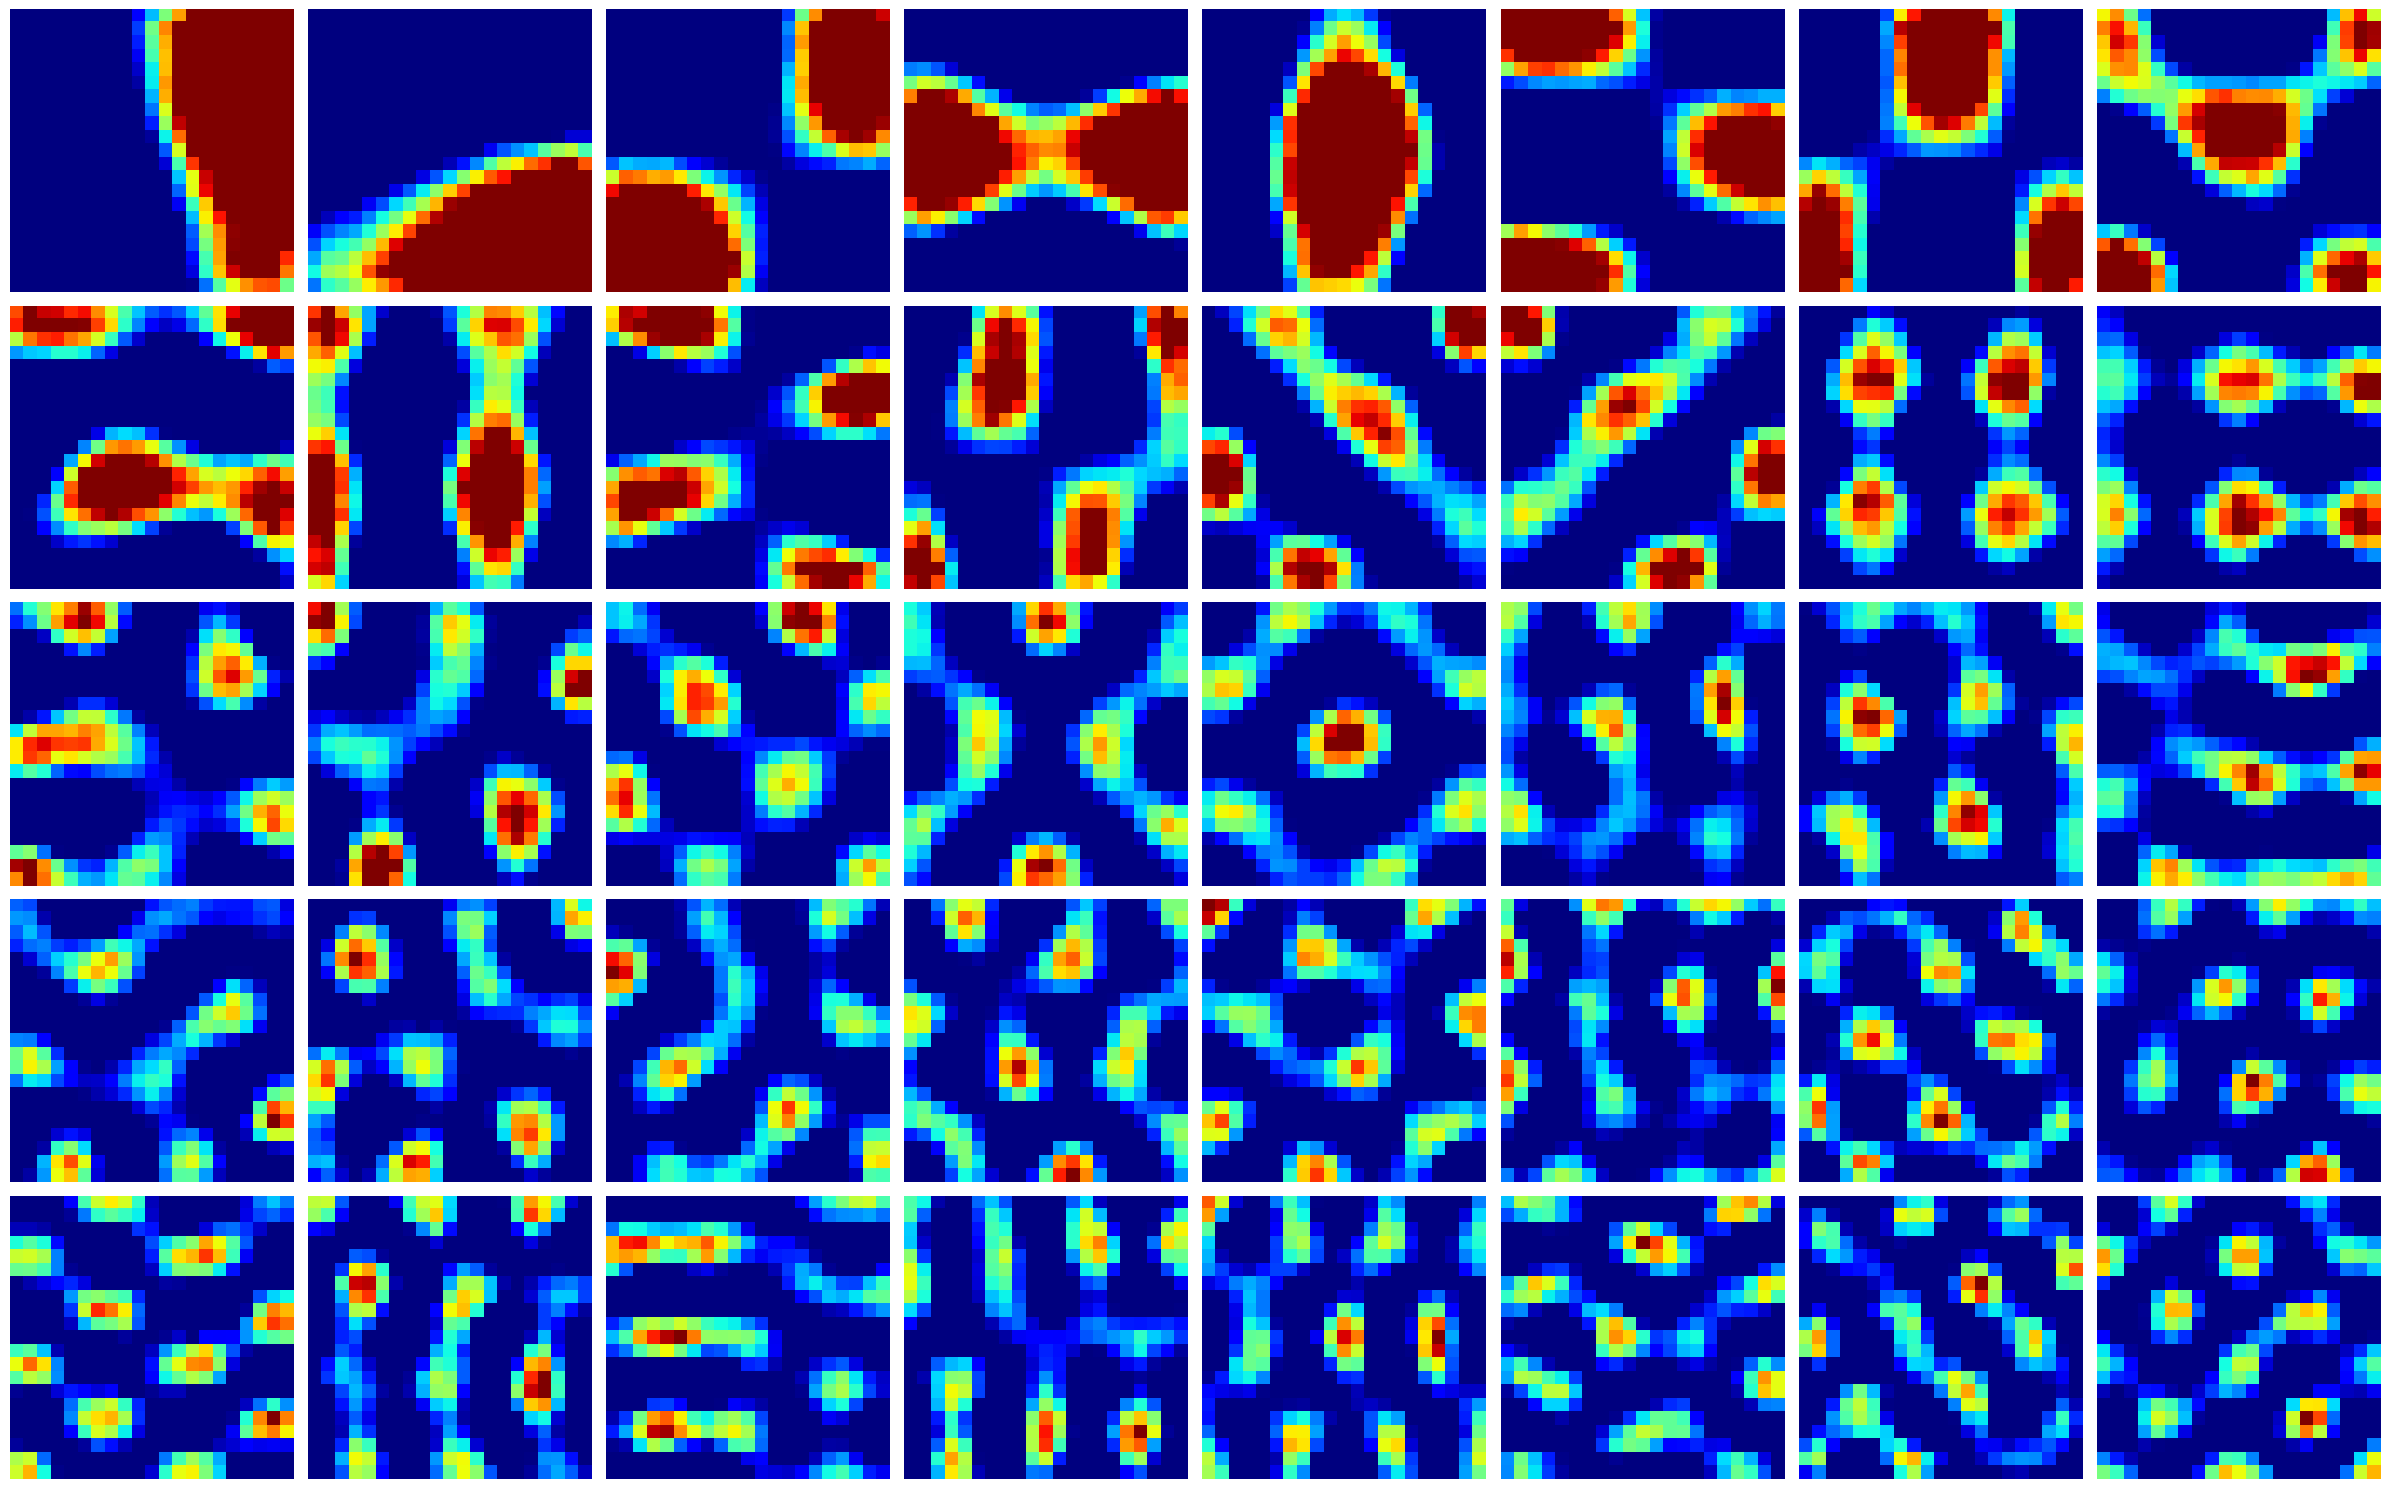

In [28]:
visualize_grid_fields(sr_imp_agent, sr_imp_agent.DR)

### Complete Agent

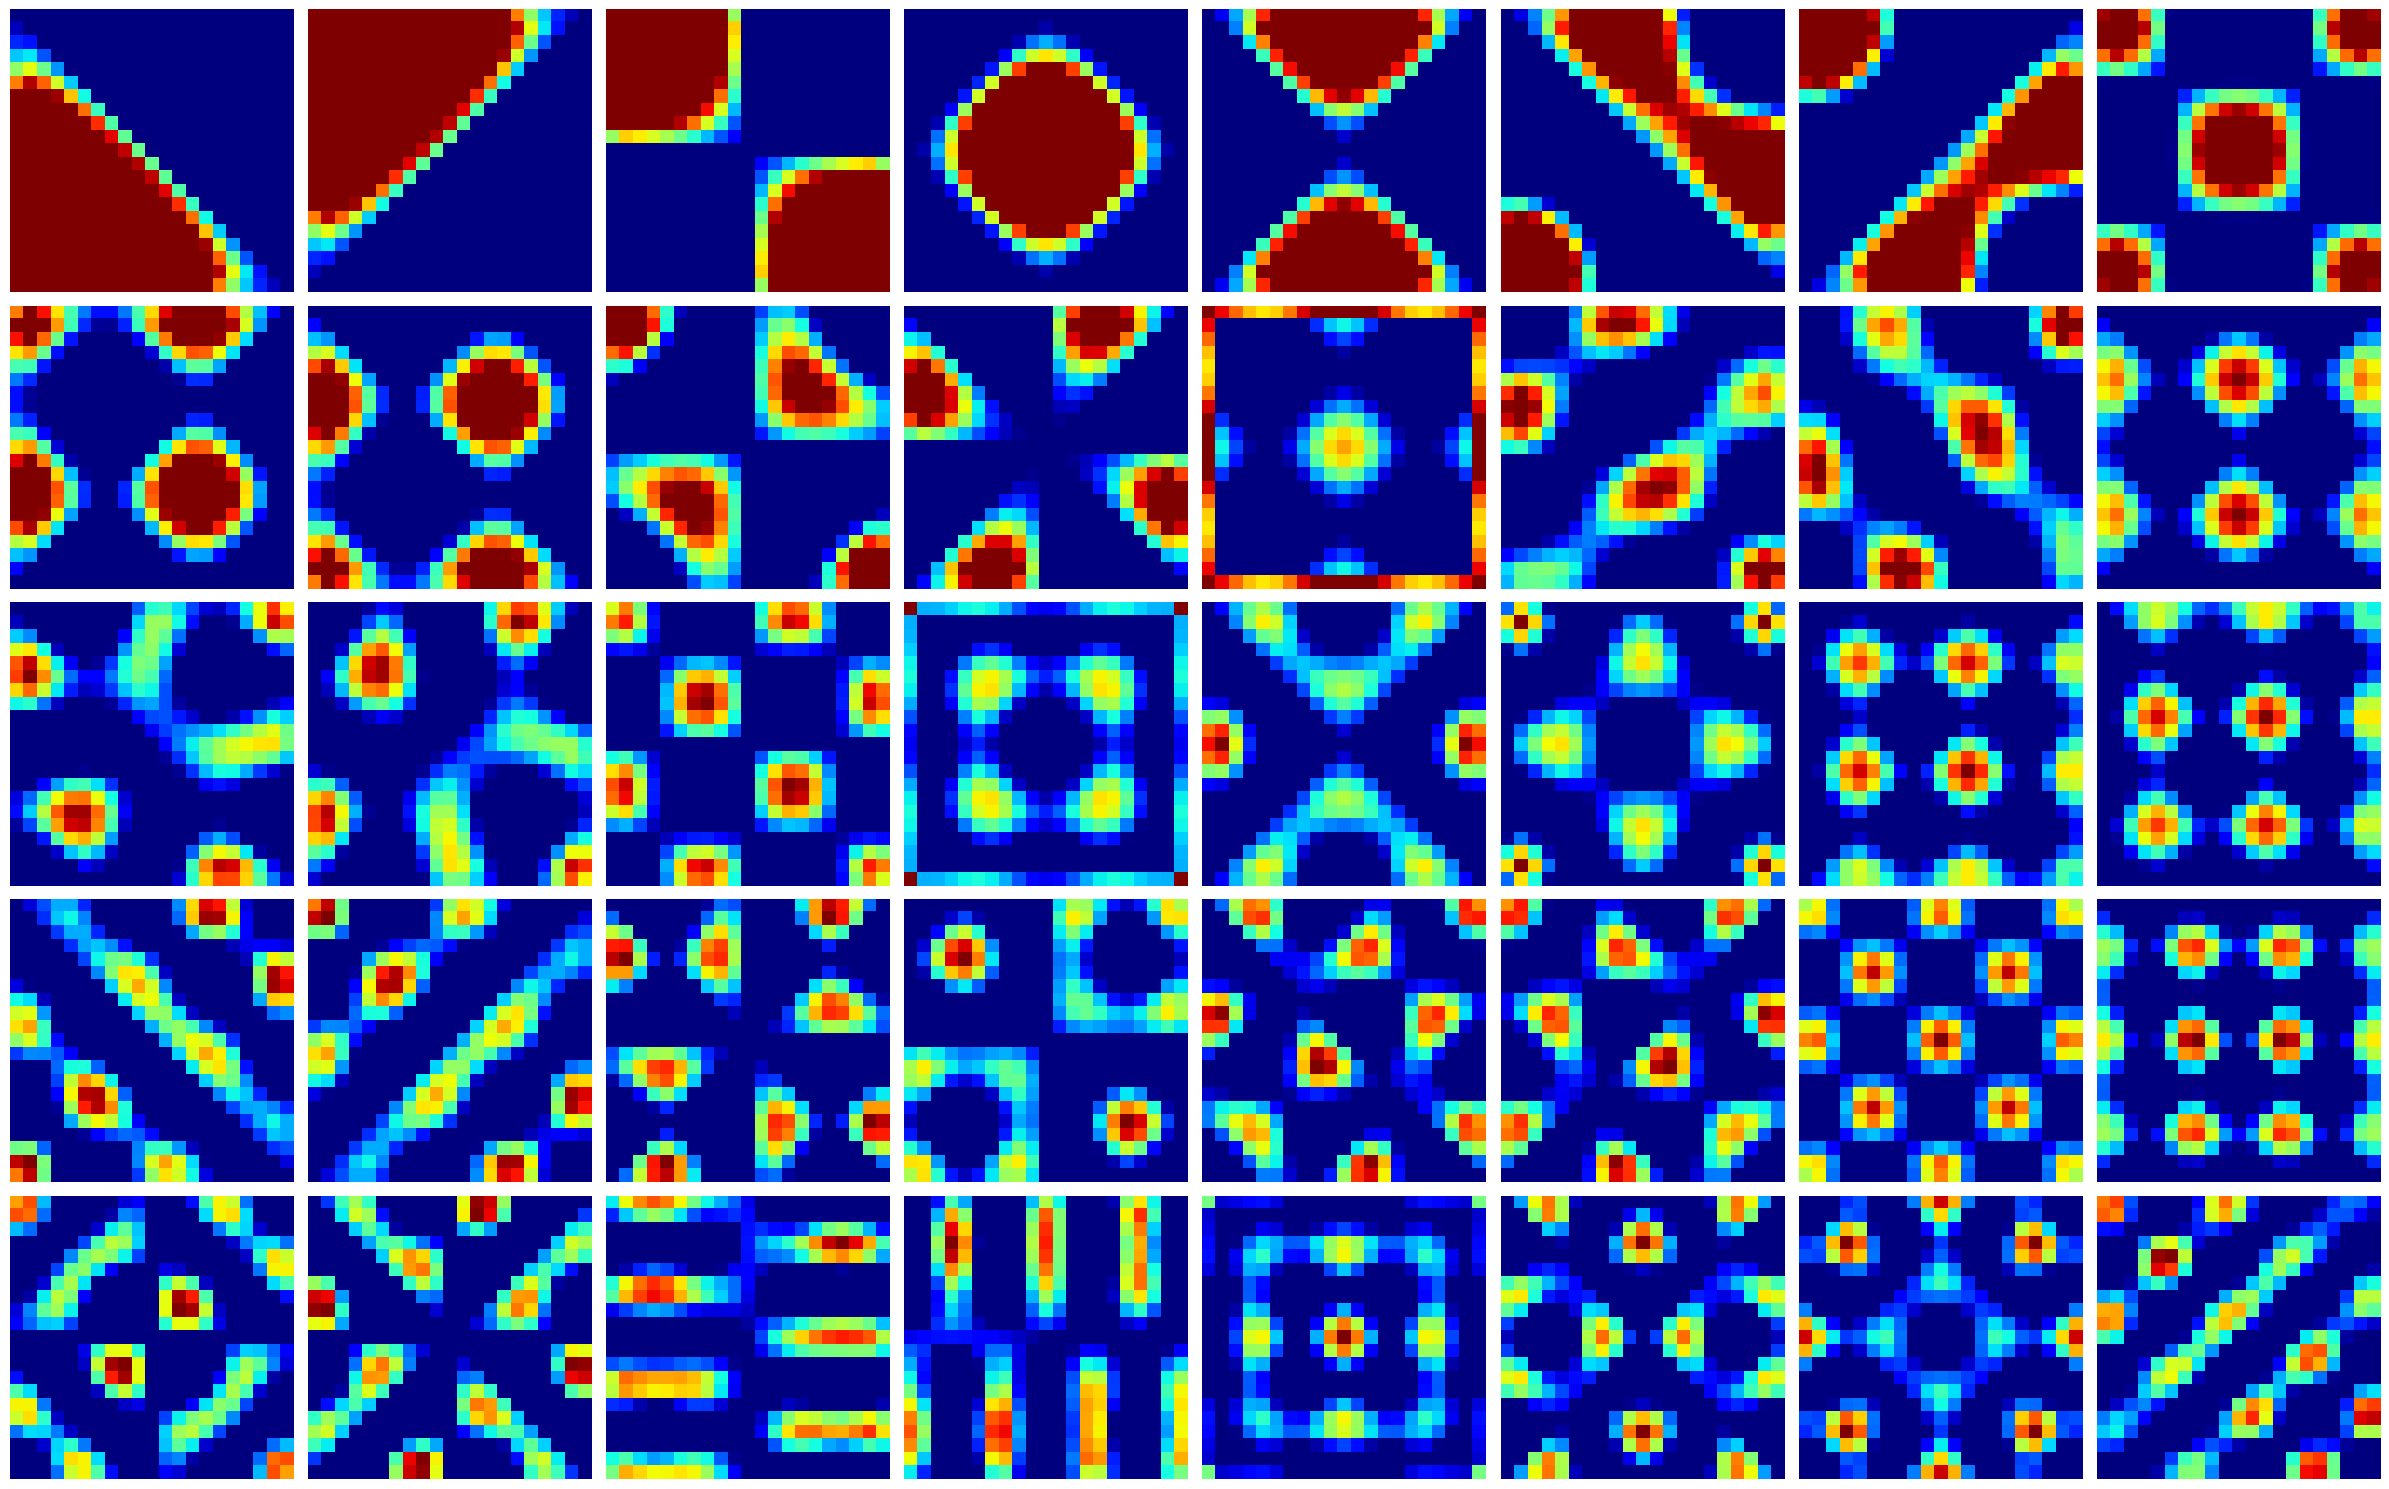

In [29]:
visualize_grid_fields(sr_imp_agent, DR_inv)

## Open Field Center Goal

### SR Agent

In [36]:
sr_agent = SR_TD(env_name="open-field-center-goal-large", reward=1, term_reward=10, num_steps=200000, policy="softmax")
sr_agent.learn(seed=seed)

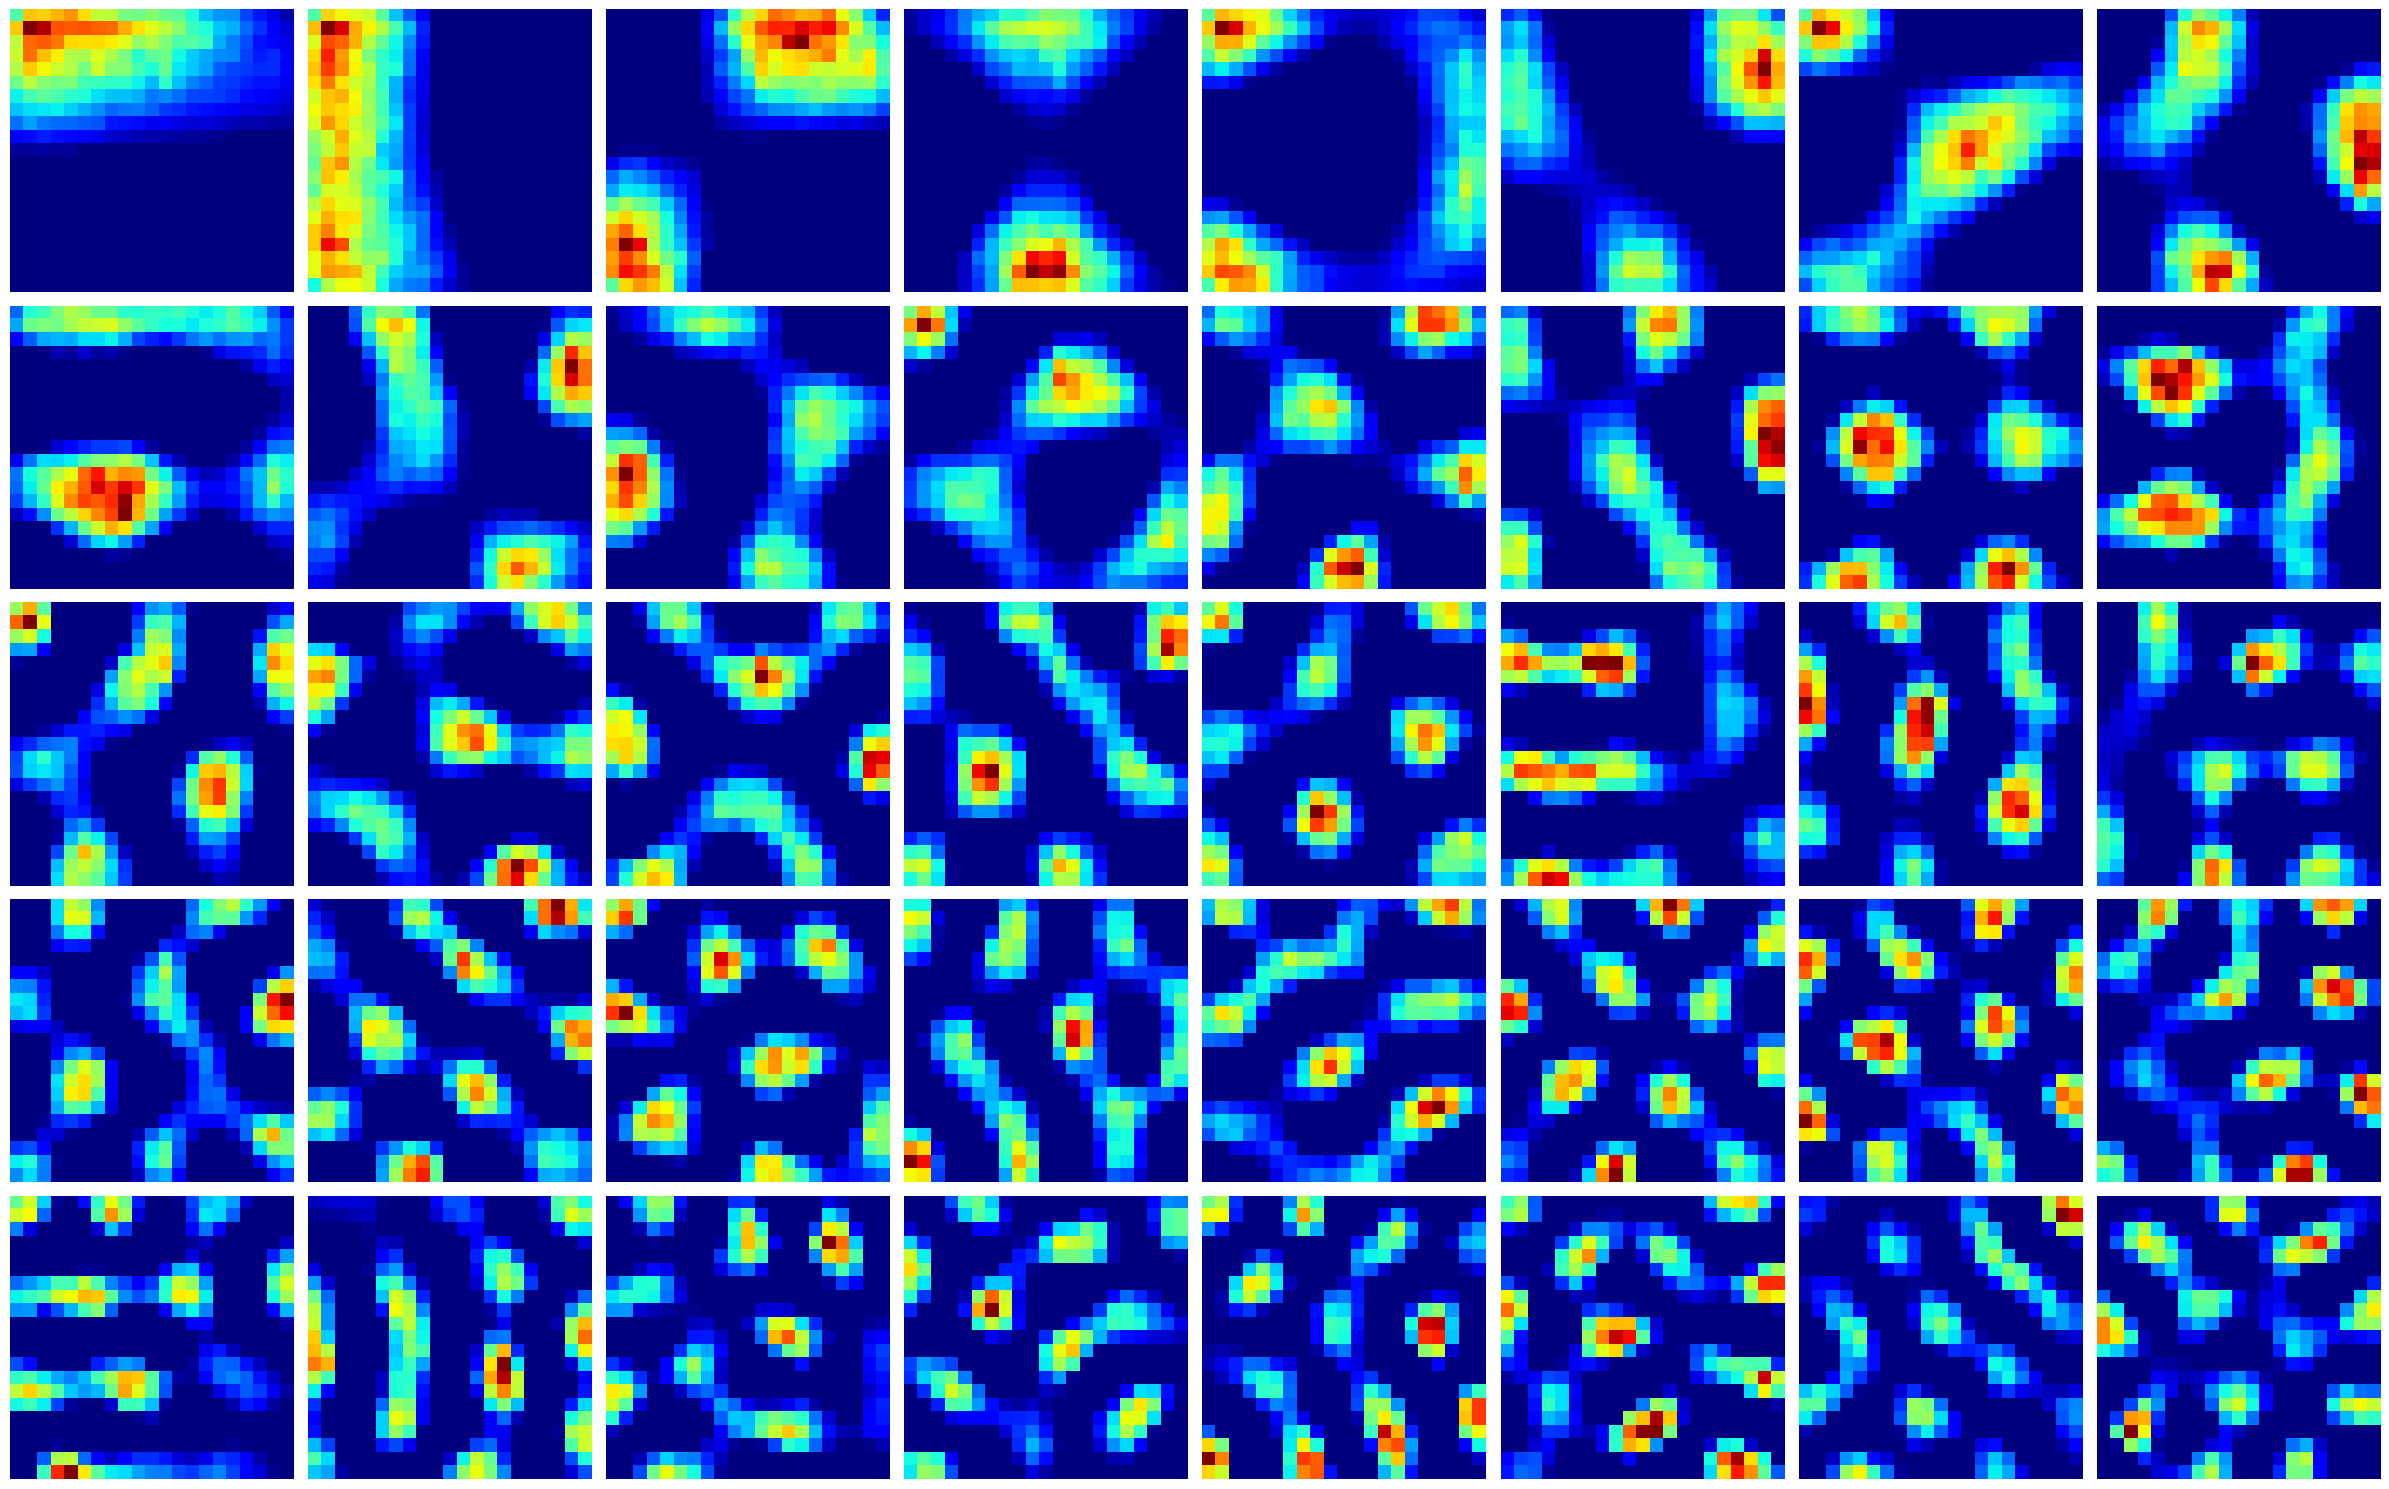

In [37]:
visualize_grid_fields(sr_agent, sr_agent.SR)

### SR-Imp Agent

In [34]:
reward = -0.1
alpha = 0.1
sr_imp_agent = LinearRL(env_name="open-field-center-goal-large", reward=reward, term_reward=10, alpha=alpha, num_steps=200000, policy="softmax", imp_samp=True)
sr_imp_agent.learn(seed=seed)

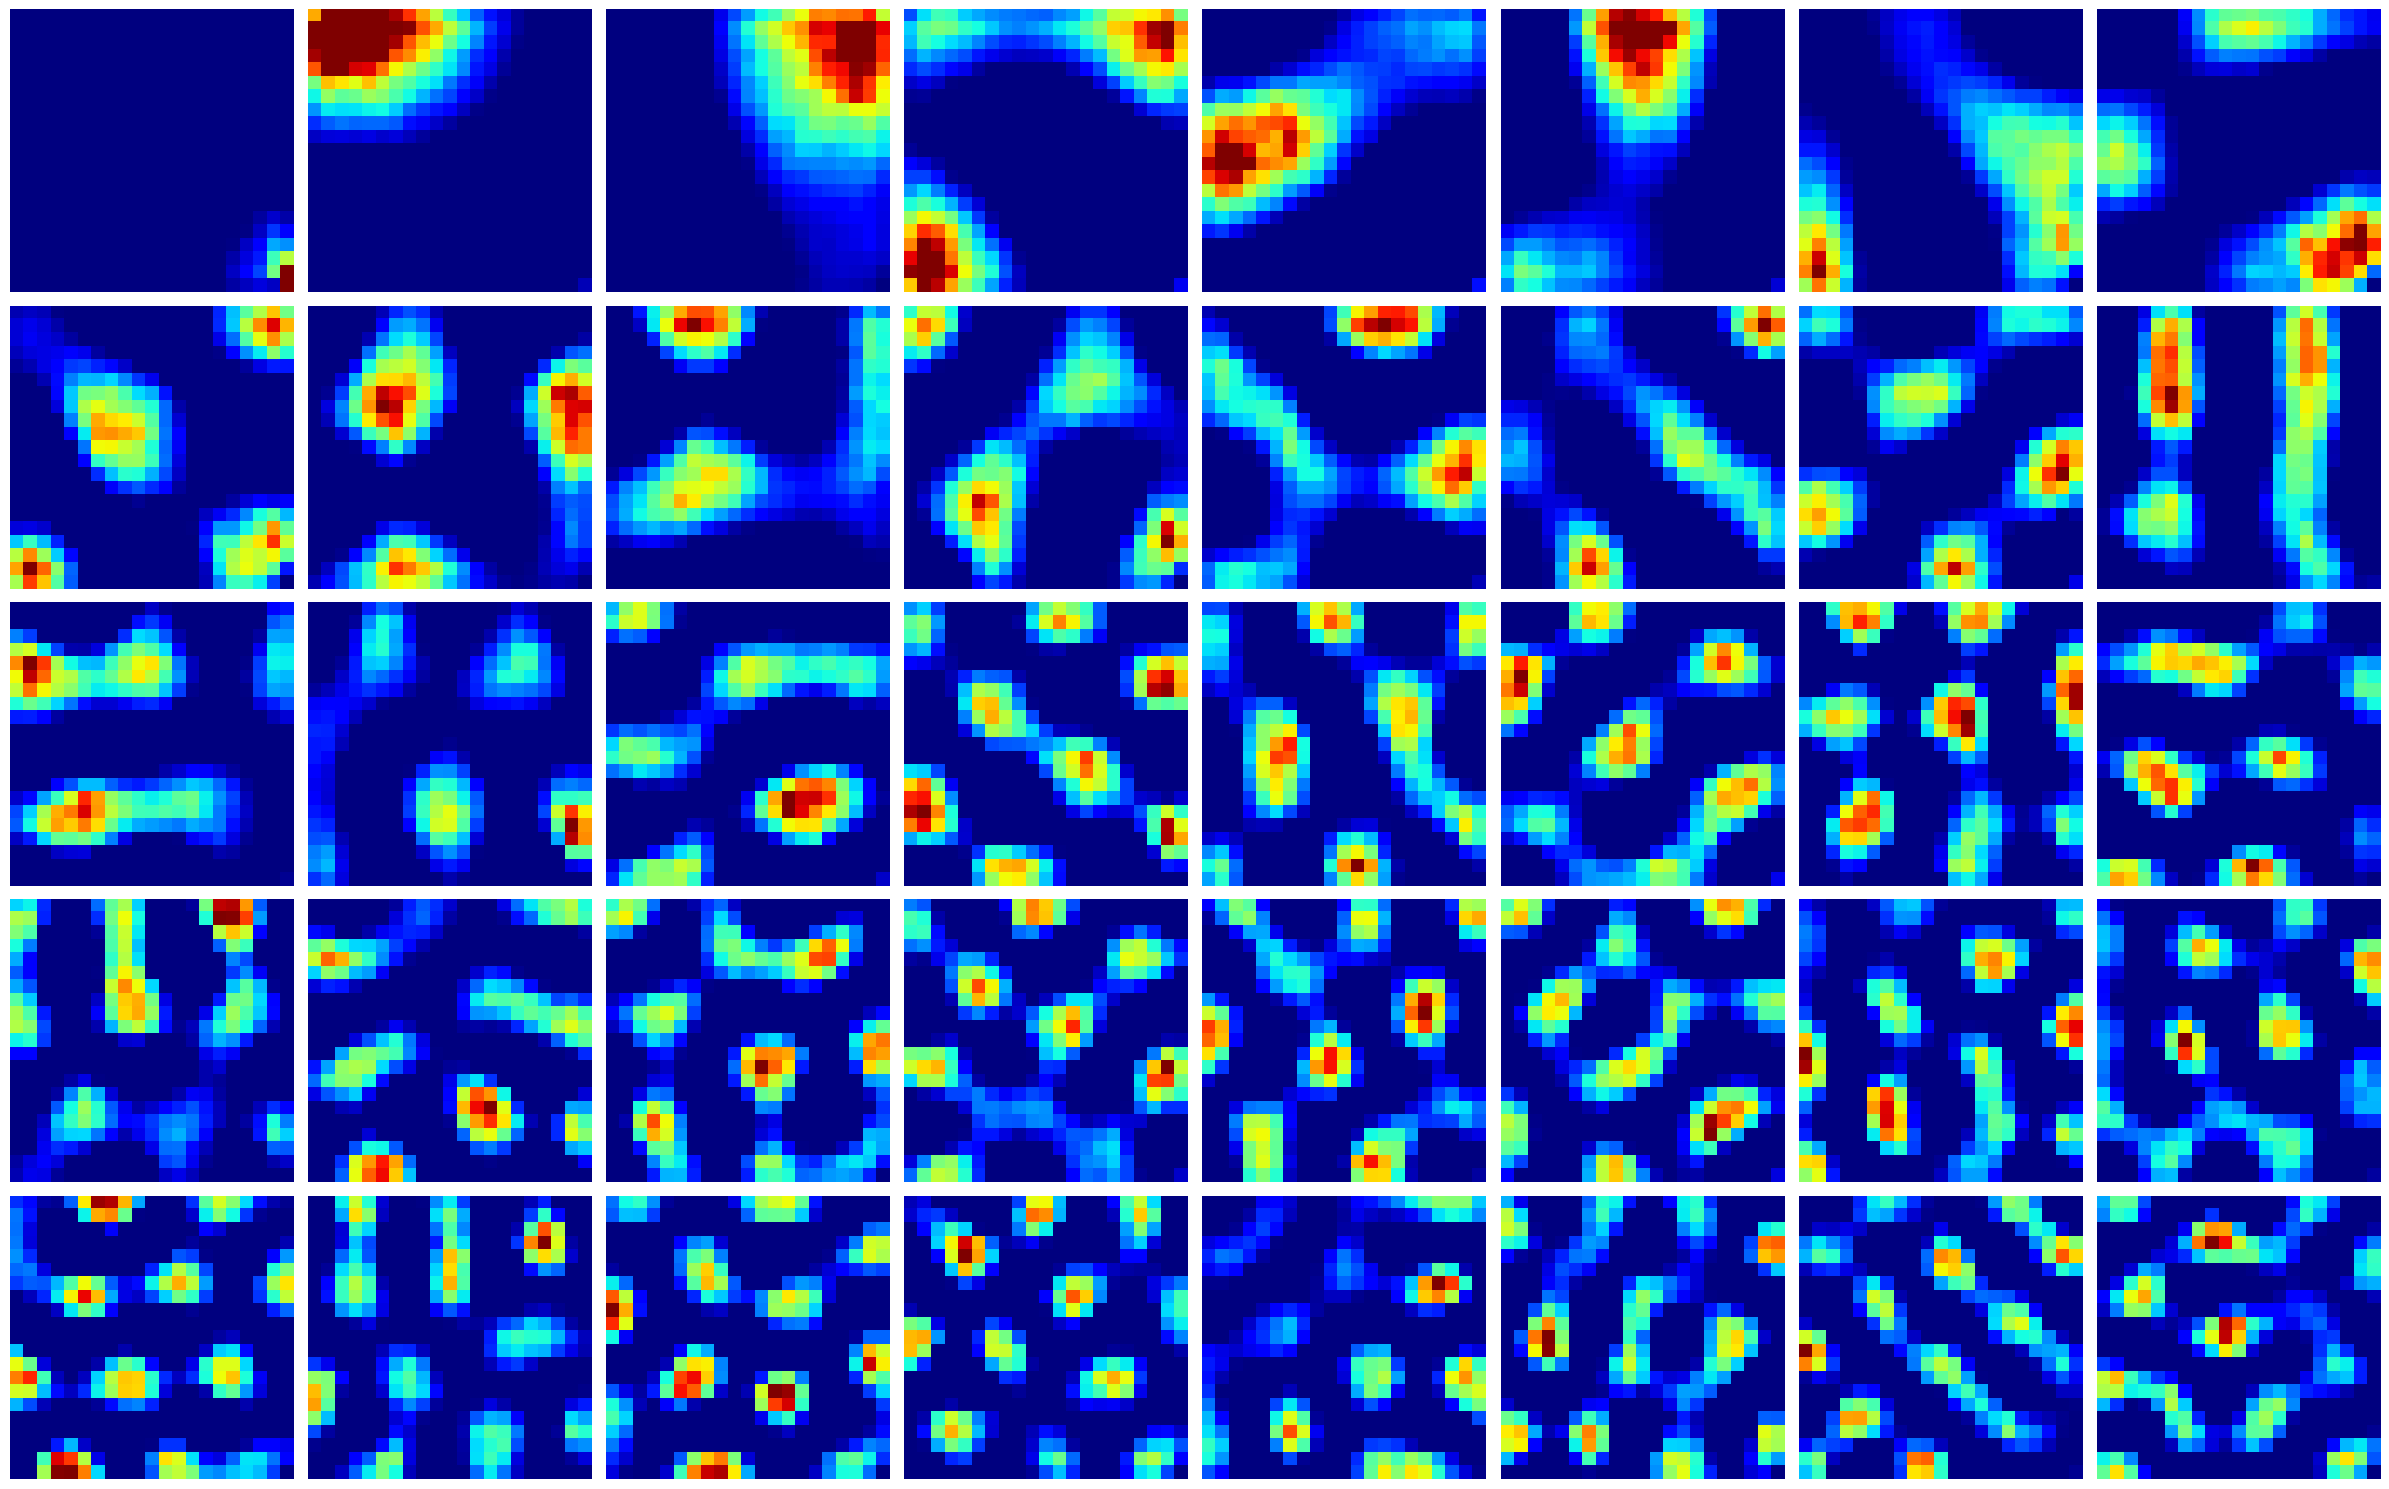

In [35]:
visualize_grid_fields(sr_imp_agent, sr_imp_agent.DR)

## Carpenter et al. (2015)

In [ ]:
agent = LinearRL(env_name="carpenter", alpha=alpha, num_steps=200000)